In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import time
from torch.optim.lr_scheduler import StepLR
import sympy as sp

In [2]:
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")

In [30]:
class Multi_Func(nn.Module):
    def __init__(self, functions, num_params, symbols, input_channels, device):
        super().__init__()
        self.device = device
        self.functions = functions
        self.num_params = num_params
        self.symbols = symbols
        self.input_channels = input_channels
        self.params = sum(self.num_params)

        self.hidden_x1 = nn.Sequential(
            nn.Conv1d(in_channels=self.input_channels, out_channels=8, kernel_size=1),
            nn.SELU(),
            nn.Conv1d(in_channels=8, out_channels=6, kernel_size=1),
            nn.SELU(),
            nn.Conv1d(in_channels=6, out_channels=4, kernel_size=1),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(64)
        )

        self.hidden_xfc = nn.Sequential(
            nn.Linear(256, 64),
            nn.SELU(),
            nn.Linear(64, 32),
            nn.SELU(),
            nn.Linear(32, 20),
            nn.SELU(),
        )

        self.hidden_x2 = nn.Sequential(
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=2, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(16),
            nn.Conv1d(in_channels=4, out_channels=2, kernel_size=3),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(8),
            nn.Conv1d(in_channels=2, out_channels=2, kernel_size=3),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(4),
        )

        self.flatten_layer = nn.Flatten()

        self.hidden_embedding = nn.Sequential(
            nn.Linear(28, 128),
            nn.SELU(),
            nn.Linear(128, 64),
            nn.SELU(),
            nn.Linear(64, self.params),
        )

    def loss_func(self, output, target):
        target_range = torch.max(target, dim=-1, keepdim=True)[0] - torch.min(target, dim=-1, keepdim=True)[0]
        target_range = torch.clamp(target_range, min=1e-6).squeeze(-1)
        #print(f"target_range: {target_range}")
        loss = ((target - output)**2)#/target_range
        #l2_reg = sum(p.pow(2.0).sum() for p in self.parameters())
        #l1_reg = sum(p.abs().sum() for p in self.parameters())

        #total_loss = loss + 0.01*l2_reg + 0.01*l1_reg
        return loss

    def evaluate_function(self, params, symbols, formula):
        var_values = {symbols[j]: params[:, j] for j in range(len(symbols))}
        lambda_func = sp.lambdify(symbols, formula, modules=['numpy'])
        #evaluated = formula.subs(var_values)
        np_values = {str(sym): var_values[sym].detach().cpu().numpy() for sym in symbols}
        #evaluated = lambda_func(**np_values)
        with np.errstate(all='ignore'): #need to fix this at some point
            evaluated = lambda_func(**np_values)
        evaluated = np.nan_to_num(evaluated, nan=0.0)
        return torch.tensor(evaluated, dtype=torch.float32, requires_grad=True) #torch.hstack([torch.from_numpy(evaluated)]) #

    def forward(self, x, n=-1):
        out = self.hidden_x1(x)
        xfc = torch.reshape(out, (n, 256))
        xfc = self.hidden_xfc(xfc)

        out = torch.reshape(out, (n, 2, 128))
        out = self.hidden_x2(out)
        cnn_flat = self.flatten_layer(out)
        encoded = torch.cat((cnn_flat, xfc), 1)
        embedding = self.hidden_embedding(encoded)
        
        start_index = 0
        losses = []
        outputs = []
        #print(self.params)
        #print(f"whole embedding: {embedding.shape}")
        
        for f in range(len(self.functions)):
            #print(f"embedding: {embedding[:, start_index:start_index+self.num_params[f]].shape}")
            output = self.evaluate_function(
                embedding[:, start_index:start_index+self.num_params[f]],
                self.symbols[f],
                self.functions[f]
            ).to(device)
            outputs.append(output)
            loss = self.loss_func(output, x[:,0,0])
            losses.append(loss)
            start_index += self.num_params[f]  
        
        #print(f"loss len: {len(losses)}")      
        '''best_index = torch.argmin(torch.tensor(losses))
        best_func = self.functions[best_index]
        best_loss, best_out = losses[best_index], outputs[best_index]'''

        stacked_outputs = torch.stack(outputs)
        stacked_losses = torch.stack(losses)
        #print(f"stacked_outputs shape: {stacked_outputs.shape}")
        #print(f"stacked_losses shape: {stacked_losses.shape}")
        best_loss, best_indexes = torch.min(stacked_losses, dim=0) 
        #print(f"best_loss shape: {best_loss.shape}")
        #print(f"best_indexes shape: {best_indexes.shape}")
        #print(f"best indexes 0: {best_indexes[0]}")
        best_out = stacked_outputs[best_indexes, -1]
        best_func = [self.functions[idx] for idx in best_indexes]
        #print(f"best_func for 0: {best_func[0]}")

        return best_out, best_loss, best_func, outputs, losses

In [5]:
import pandas as pd
df = pd.read_csv('FeynmanEquations.csv')

functions = []
num_vars_per_func = []

for _, row in df.iterrows():
    formula = row['Formula']
    num_vars = row['# variables']
    function_details = {
        'formula': formula,
        'variables': []
    }
    
    for i in range(1, 11):  
        v_name = row.get(f'v{i}_name', None)
        v_low = row.get(f'v{i}_low', None)
        v_high = row.get(f'v{i}_high', None)
        
        if pd.notna(v_name):
            function_details['variables'].append({
                'name': v_name,
                'low': v_low,
                'high': v_high
            })
    
    functions.append(function_details)
    num_vars_per_func.append(num_vars)

'''for i, func in enumerate(functions):
    print(f"Function {i+1}:")
    print(f"  Formula: {func['formula']}")
    print(f"  Number of Variables: {num_vars_per_func[i]}")
    print("  Variables:")
    for var in func['variables']:
        print(f"    - Name: {var['name']}, Range: ({var['low']}, {var['high']})")
    print()'''


'for i, func in enumerate(functions):\n    print(f"Function {i+1}:")\n    print(f"  Formula: {func[\'formula\']}")\n    print(f"  Number of Variables: {num_vars_per_func[i]}")\n    print("  Variables:")\n    for var in func[\'variables\']:\n        print(f"    - Name: {var[\'name\']}, Range: ({var[\'low\']}, {var[\'high\']})")\n    print()'

In [6]:
def generate_function(function, sample_size, device):
    hold = []
    sympy_symbols = []
    
    for var in function["variables"]:
        sym = sp.symbols(var["name"])
        sympy_symbols.append(sym)
        min_val = var["low"]
        max_val = var["high"]
        v = (max_val - min_val) * torch.rand(sample_size, 1, 1) + min_val
        hold.append(v)
    
    params = torch.stack(hold)
    params = torch.atleast_2d(params)
    params = torch.transpose(params, 0, 1)
    params = torch.transpose(params, 1, 2)
    params = params.to(device)

    formula = sp.sympify(function["formula"])
    
    results = []
    for i in range(sample_size):
        var_values = {sympy_symbols[j]: params[i, 0, j].item() for j in range(len(sympy_symbols))}
        evaluated = formula.subs(var_values)
        results.append(float(evaluated))
    
    return results, formula, sympy_symbols, params

In [7]:
sample_size = 1000
hold = []
for f in functions[0:10]:
    try:
        results = generate_function(f, sample_size, device)
        hold.append(results)
    except Exception as e:
        print(f"Error processing function {f}: {e}")
hold_data = [torch.tensor(l[0]) for l in hold]
data = torch.stack(hold_data).reshape(-1)
print(data.shape)


torch.Size([10000])


In [9]:
hold_formulas = [l[1] for l in hold]
hold_symbols = [l[2] for l in hold]
hold_params = [l[3] for l in hold]
hold_num_params = [len(l[2]) for l in hold]

dataloader = DataLoader(data, batch_size=50, shuffle=True)

In [10]:
def evaluate_function(params, symbols, formula):
    print(len(symbols))
    print(params.shape)
    var_values = {symbols[j]: params[:, j].item() for j in range(len(symbols))}
    print(var_values)
    print(formula)
    evaluated = formula.subs(var_values)
    return float(evaluated)

In [10]:
evaluate_function(hold_params[10][0], hold_symbols[10], hold_formulas[10])

2
torch.Size([1, 2, 1])
{q2: 3.6118147373199463, Ef: 1.2339305877685547}
Ef*q2


4.456728681732329

In [27]:
def loss_func(self, output, target):
    target_range = torch.max(target, dim=-1, keepdim=True)[0] - torch.min(target, dim=-1, keepdim=True)[0]
    target_range = torch.clamp(target_range, min=1e-6).squeeze(-1)
    #print(f"target_range: {target_range}")
    loss = torch.mean((target - output)**3)/target_range
    l2_reg = sum(p.pow(2.0).sum() for p in self.parameters())
    l1_reg = sum(p.abs().sum() for p in self.parameters())

    total_loss = loss + 0.01*l2_reg + 0.01*l1_reg
    return total_loss

In [31]:
model = Multi_Func(functions=hold_formulas, num_params=hold_num_params, symbols=hold_symbols, input_channels=1, device=device).to(device)
#loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

epochs = 10
for epoch in range(epochs):
    start_time = time.time()
    train_loss = 0.0
    total_num = 0
    model.train()
    
    for train_batch in dataloader:
        train_batch = train_batch.unsqueeze(1).unsqueeze(2).to(device)
        optimizer.zero_grad()
        best_out,_,_,_,_ = model(train_batch)
        #print(f"best_out: {best_out}")
        #print(f"train_batch: {train_batch[:, 0, 0]}")
        loss = loss_func(model, best_out, train_batch[:, 0, 0])
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * best_out.shape[0]
        total_num += best_out.shape[0]
    scheduler.step()
    train_loss /= total_num
    print(f"epoch : {epoch}/{epochs}, loss = {train_loss:.8f}")
    print(f"--- {time.time() - start_time} seconds ---")

epoch : 0/10, loss = 65.85648902
--- 4.27775239944458 seconds ---
epoch : 1/10, loss = 58.18643760
--- 4.036761045455933 seconds ---
epoch : 2/10, loss = 60.86588296
--- 3.952829360961914 seconds ---
epoch : 3/10, loss = 59.95633340
--- 4.047475814819336 seconds ---
epoch : 4/10, loss = 62.33361556
--- 4.383310794830322 seconds ---
epoch : 5/10, loss = 63.65317568
--- 4.228999614715576 seconds ---
epoch : 6/10, loss = 61.08655823
--- 4.075994491577148 seconds ---
epoch : 7/10, loss = 62.87437754
--- 4.292018413543701 seconds ---
epoch : 8/10, loss = 63.13999753
--- 4.221972703933716 seconds ---
epoch : 9/10, loss = 61.87069768
--- 4.184945583343506 seconds ---


torch.Size([100])


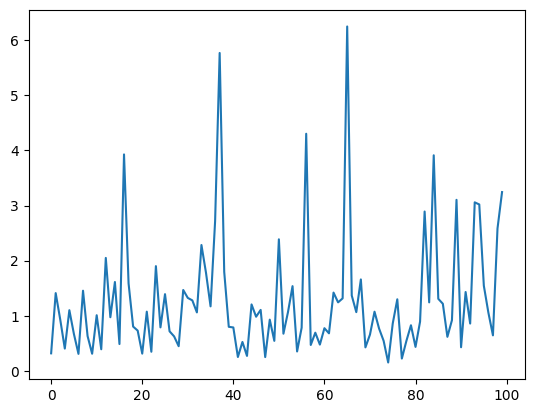

In [13]:
r = np.random.randint(data.shape[0])
print(data[r].shape)
plt.plot(data[r].detach().numpy());